In [27]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [28]:
SIZE = 256
num_images = 200

In [29]:
folder_names = glob.glob("dataset/segmentation/raw/*")
images = []

for folder in folder_names:
    print(folder)
    image_names = glob.glob(folder + '/*.jpg')
    print(image_names)
    images.extend([cv2.imread(img, 0) for img in image_names])

resized_images = []

for image in images:
    # Resize the image to a specific width and height
    resized_image = cv2.resize(image, (SIZE, SIZE))
    resized_images.append(resized_image)

# Convert the list of resized images to a NumPy array
image_dataset = np.array(resized_images)
# Convert the list of images to a NumPy array
# image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

dataset/segmentation/raw\Video01
['dataset/segmentation/raw\\Video01\\0001.jpg', 'dataset/segmentation/raw\\Video01\\0002.jpg', 'dataset/segmentation/raw\\Video01\\0003.jpg', 'dataset/segmentation/raw\\Video01\\0004.jpg', 'dataset/segmentation/raw\\Video01\\0005.jpg', 'dataset/segmentation/raw\\Video01\\0006.jpg', 'dataset/segmentation/raw\\Video01\\0007.jpg', 'dataset/segmentation/raw\\Video01\\0008.jpg', 'dataset/segmentation/raw\\Video01\\0009.jpg', 'dataset/segmentation/raw\\Video01\\0010.jpg', 'dataset/segmentation/raw\\Video01\\0011.jpg', 'dataset/segmentation/raw\\Video01\\0012.jpg', 'dataset/segmentation/raw\\Video01\\0013.jpg', 'dataset/segmentation/raw\\Video01\\0014.jpg', 'dataset/segmentation/raw\\Video01\\0015.jpg', 'dataset/segmentation/raw\\Video01\\0016.jpg', 'dataset/segmentation/raw\\Video01\\0017.jpg', 'dataset/segmentation/raw\\Video01\\0018.jpg', 'dataset/segmentation/raw\\Video01\\0019.jpg', 'dataset/segmentation/raw\\Video01\\0020.jpg', 'dataset/segmentation/raw\

In [30]:
folder_names = glob.glob("dataset/segmentation/labelled/*")
masks = []

for folder in folder_names:
    print(folder)
    mask_names = glob.glob(folder + '/*.jpg')
    print(mask_names)
    masks.extend([cv2.imread(mask, 0) for mask in mask_names])

resized_masks = []

for mask in masks:
    # Resize the image to a specific width and height
    resized_mask = cv2.resize(mask, (SIZE, SIZE))
    resized_masks.append(resized_mask)

threshold_value = 127

binary_masks = [cv2.threshold(mask, threshold_value, 255, cv2.THRESH_BINARY)[1] for mask in resized_masks]

# Convert the list of resized images to a NumPy array
mask_dataset = np.array(binary_masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

dataset/segmentation/labelled\Video01_GT
['dataset/segmentation/labelled\\Video01_GT\\Video01_GT_001.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_002.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_003.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_004.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_005.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_006.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_007.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_008.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_009.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_010.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_011.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_012.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_013.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Video01_GT_014.jpg', 'dataset/segmentation/labelled\\Video01_GT\\Vide

In [31]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (2683, 256, 256, 1)
Mask data shape is:  (2683, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [32]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset,
    mask_dataset,
    test_size = 0.20,
    random_state = 42
)

1432


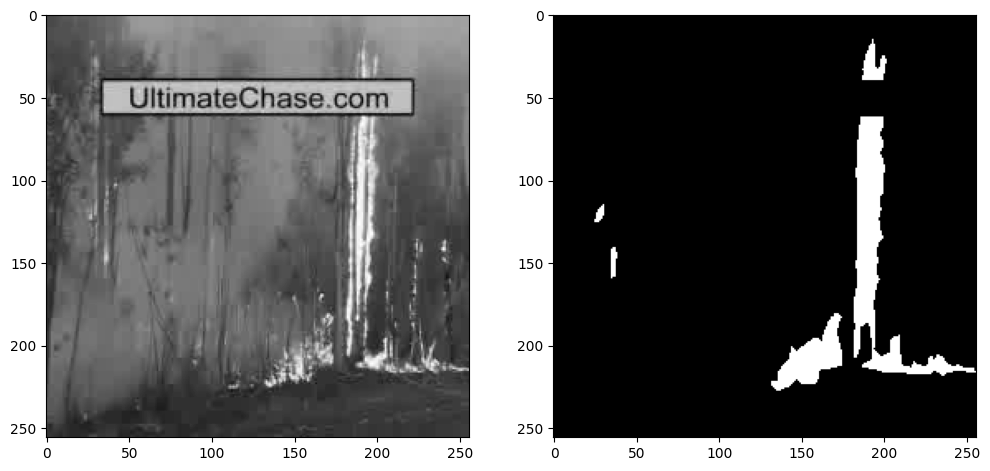

In [34]:
import random

image_number = random.randint(0, len(X_train)-1)
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')

plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [35]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [36]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [37]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

sigmoid


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [38]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4621s 34s/step - accuracy: 0.9356 - loss: 0.2212 - val_accuracy: 0.1849 - val_loss: 2.2777
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4991s 37s/step - accuracy: 0.9776 - loss: 0.0692 - val_accuracy: 0.9492 - val_loss: 0.1670
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4743s 35s/step - accuracy: 0.9824 - loss: 0.0504 - val_accuracy: 0.9477 - val_loss: 0.2227
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4743s 35s/step - accuracy: 0.9844 - loss: 0.0431 - val_accuracy: 0.9195 - val_loss: 0.2549
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4660s 35s/step - accuracy: 0.9868 - loss: 0.0354 - val_accuracy: 0.9393 - val_loss: 0.1612
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4663s 35s/step - accuracy: 0.9880 - loss: 0.0315 - val_accuracy: 0.9896 - val_loss: 0.0273
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4650s 34s/step - accuracy: 0.9897 - loss: 0.0268 - val_accuracy: 0.9909 - val_loss: 0.0237
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 4654s 34s/step - accuracy: 0.9906 - loss: 0

In [39]:
#Save the model for future use
model.save('models/segmentation_model.hdf5')

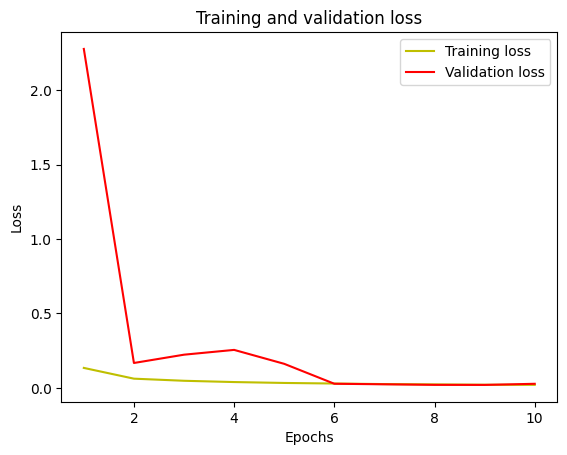

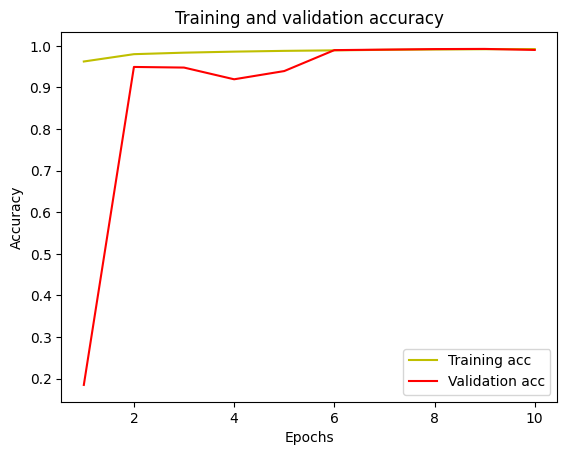

In [40]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
from keras.models import load_model

model = load_model('models/segmentation_model.hdf5')

In [56]:
print(X_test.shape)
print(y_test.shape)

(537, 256, 256, 1)
(537, 256, 256, 1)


In [58]:
X_test_array = np.array(X_test)
y_test_array = np.array(y_test)
print(X_test_array.shape)
print(y_test_array.shape)

(537, 256, 256, 1)
(537, 256, 256, 1)


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the test data
y_pred_prob = model.predict(X_test_array).ravel()

# Check the shape of y_pred_prob
print(f"y_pred_prob shape: {y_pred_prob.shape}")

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_array, y_pred_prob)

# Calculate the AUC
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3:00 12s/step

KeyboardInterrupt: 

In [42]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 11s/step


In [43]:
from tensorflow.keras.metrics import MeanIoU

In [44]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9025649


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


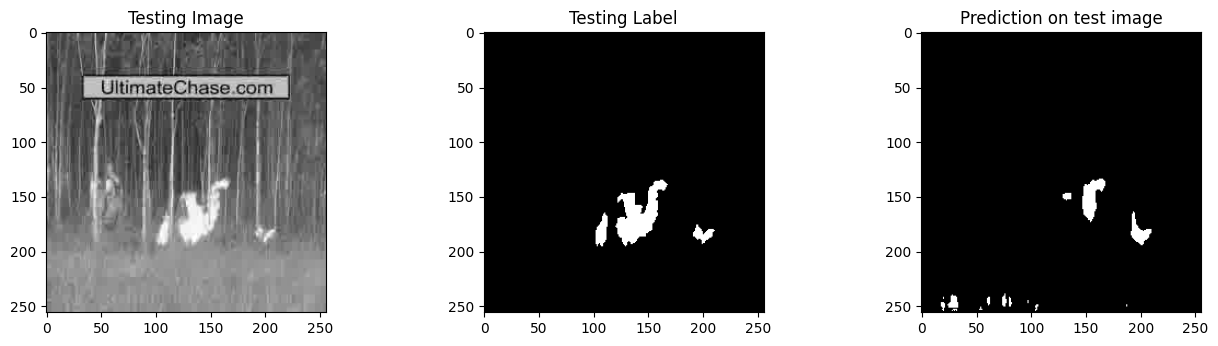

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


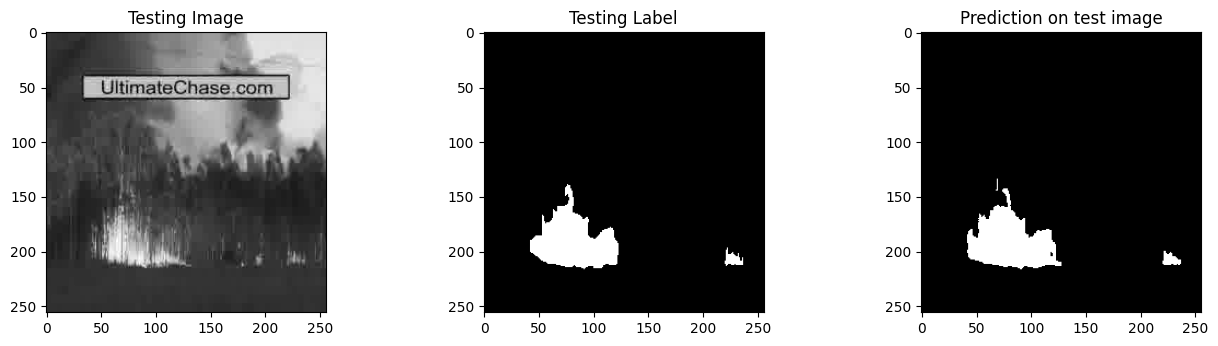

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


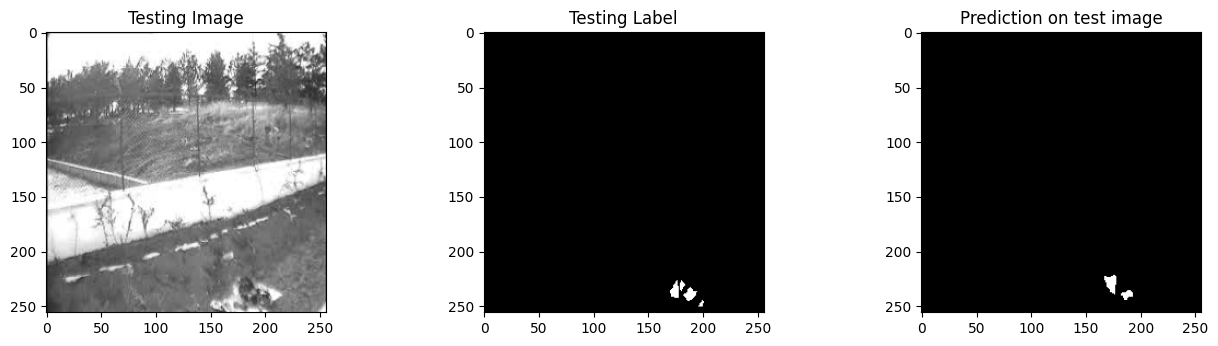

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


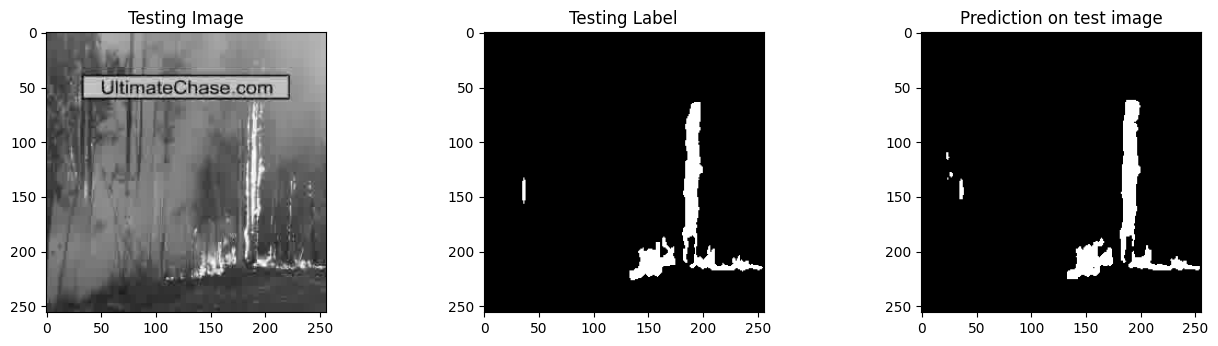

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


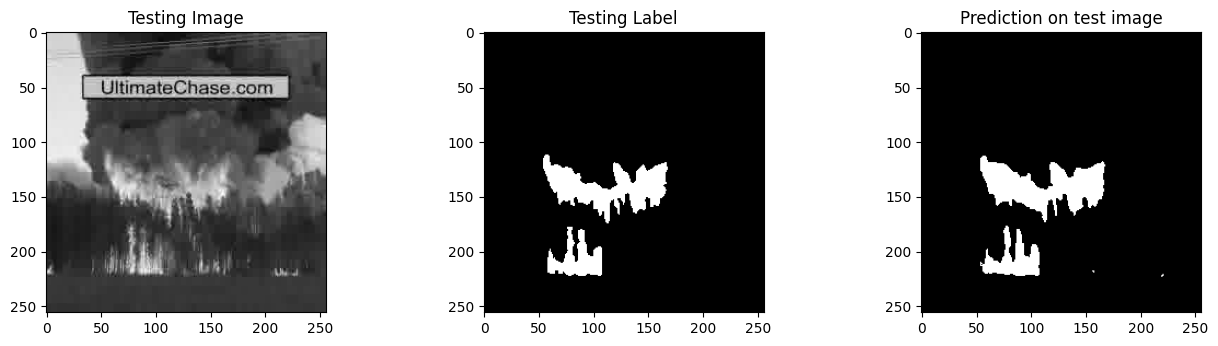

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


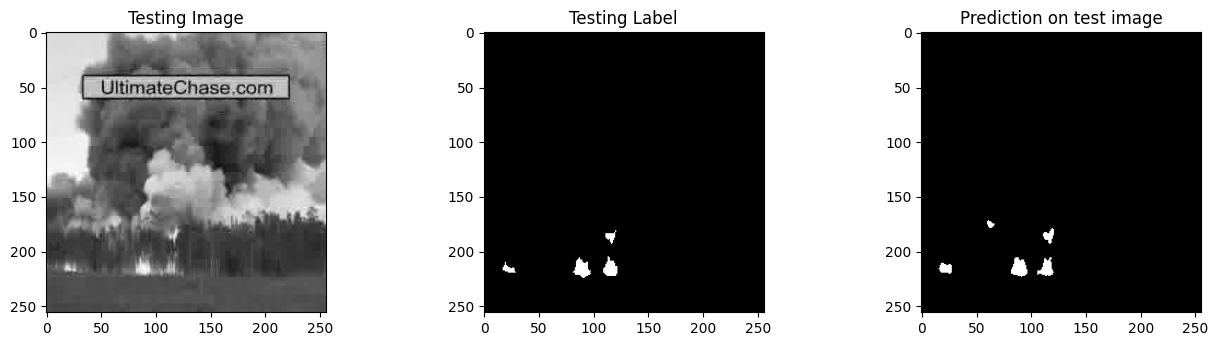

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


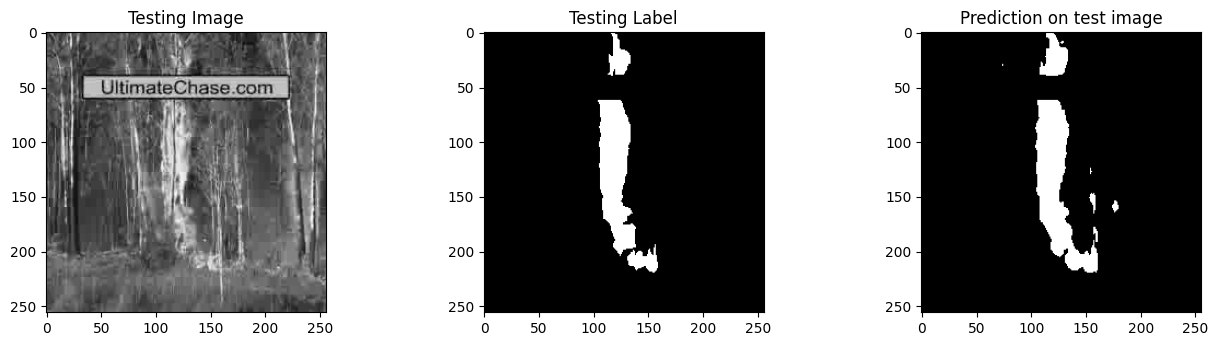

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


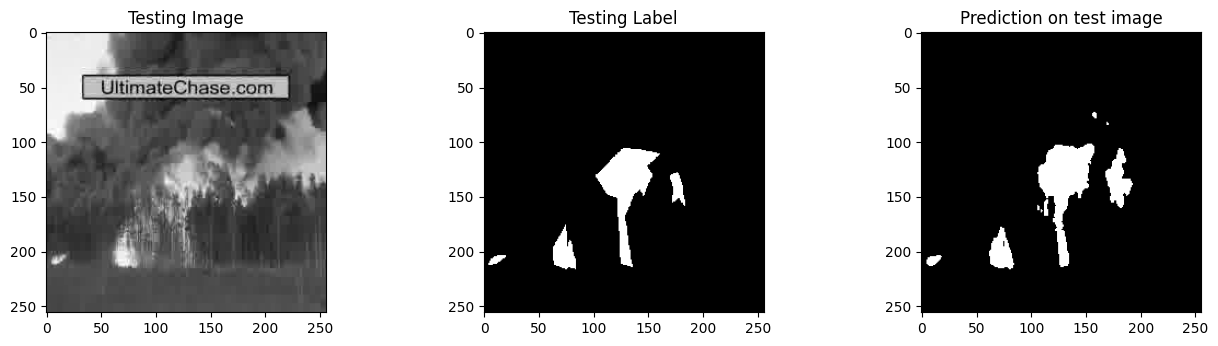

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


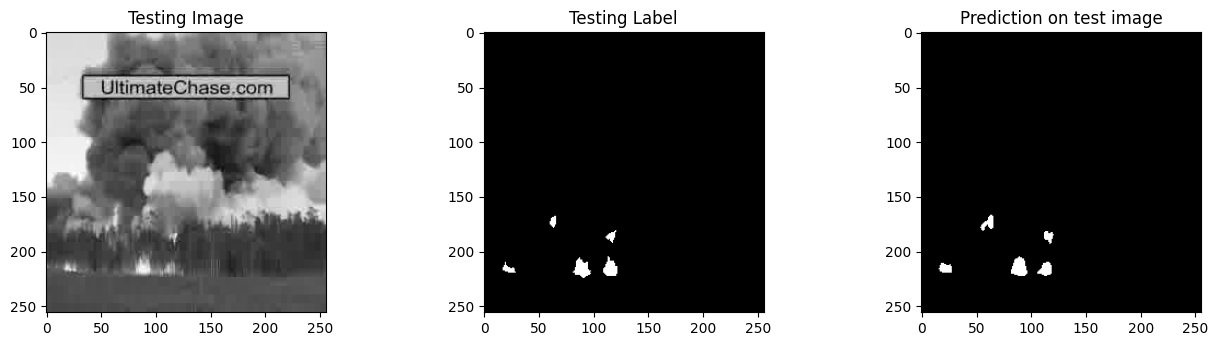

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


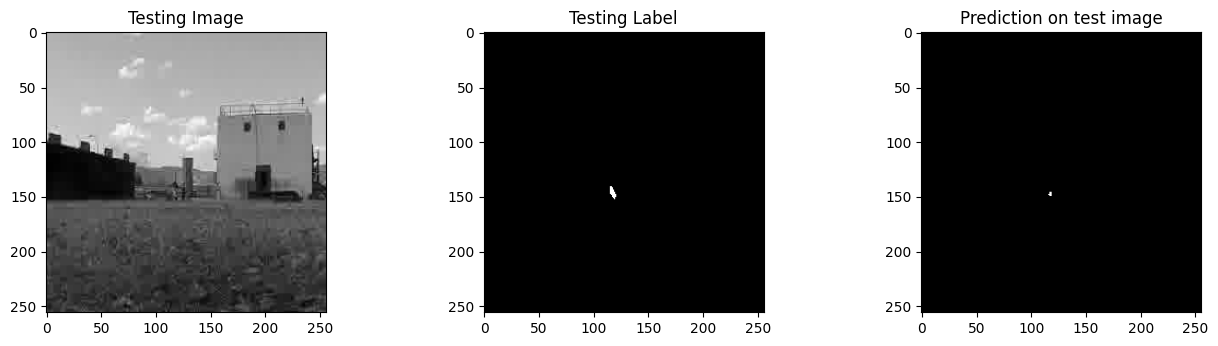

In [60]:
# threshold = 0.5
# test_img_number = random.randint(0, len(X_test)-1)
# test_img = X_test[test_img_number]
# ground_truth=y_test[test_img_number]
# test_img_input=np.expand_dims(test_img, 0)
# print(test_img_input.shape)
# prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
# print(prediction.shape)

# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')

# plt.show()

import random

threshold = 0.4

# Generate 10 random indices
random_indices = random.sample(range(len(X_test)), 10)

# Iterate over the random indices
for index in random_indices:
    test_img = X_test[index]
    ground_truth = y_test[index]
    test_img_input = np.expand_dims(test_img, 0)

    
    # Obtain the prediction
    prediction = (model.predict(test_img_input)[0, :, :, 0] > threshold).astype(np.uint8)
    
    # Plotting the results
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:, :, 0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:, :, 0], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


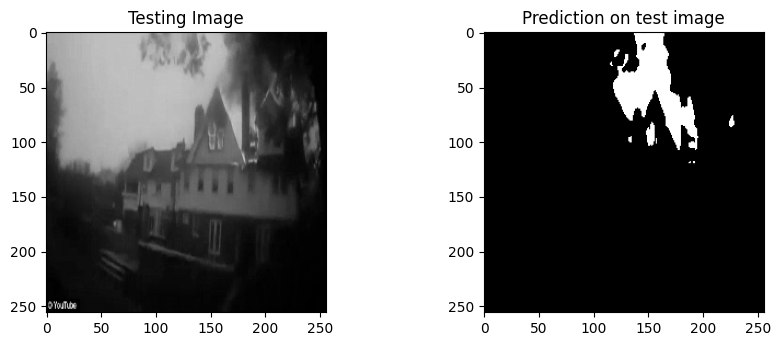

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


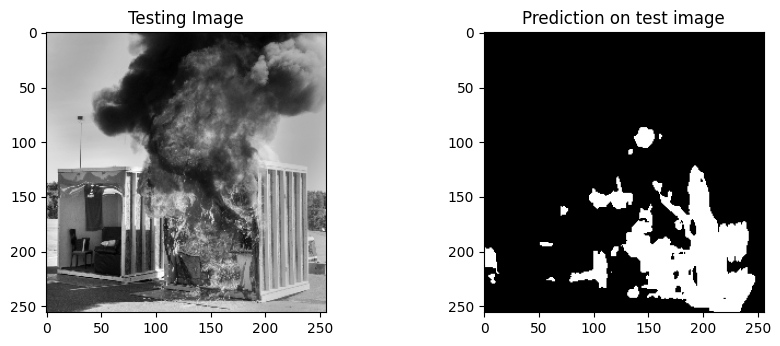

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


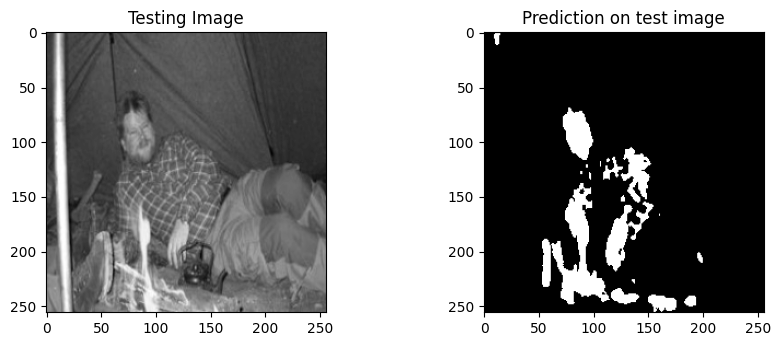

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


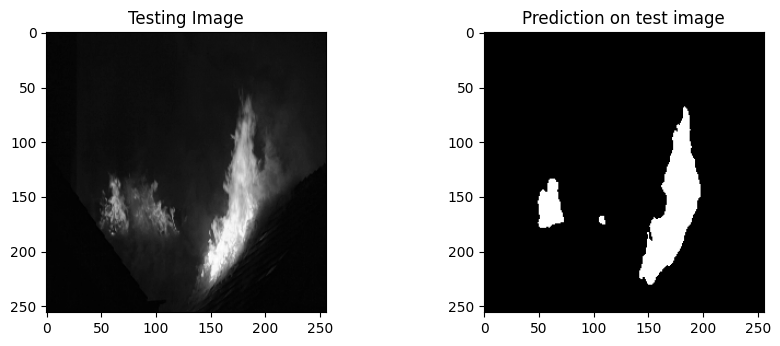

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


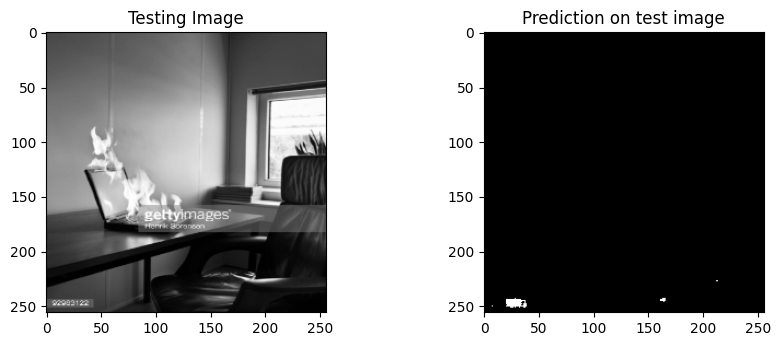

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


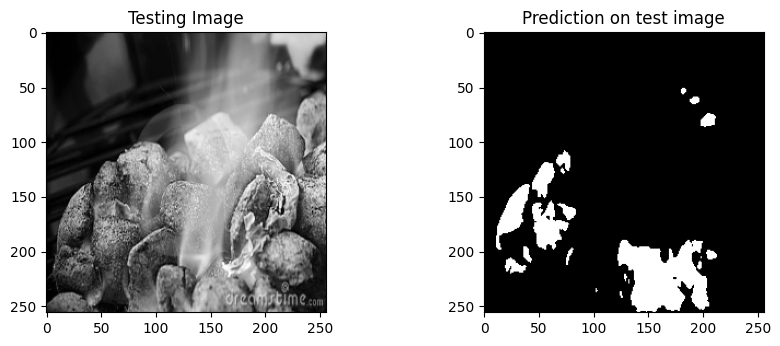

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


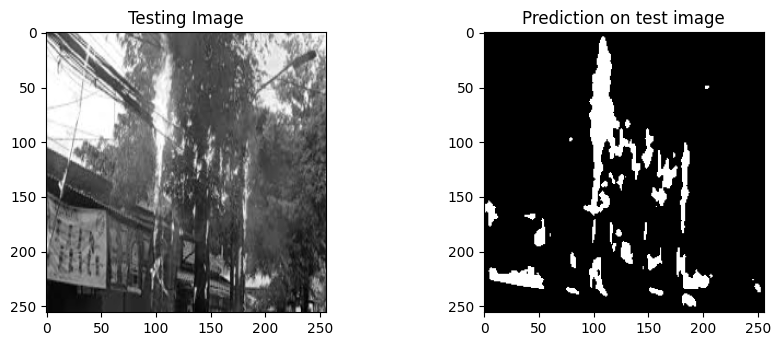

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


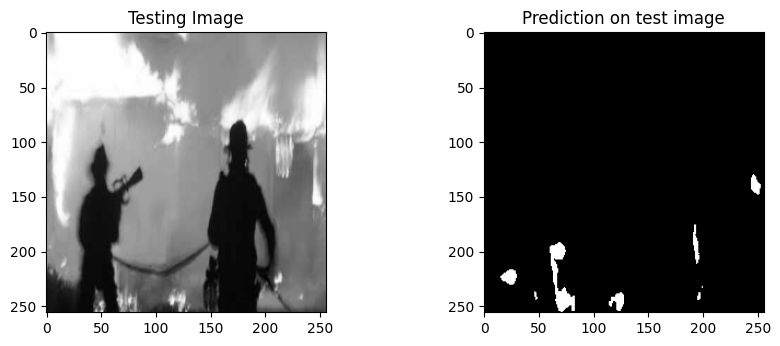

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


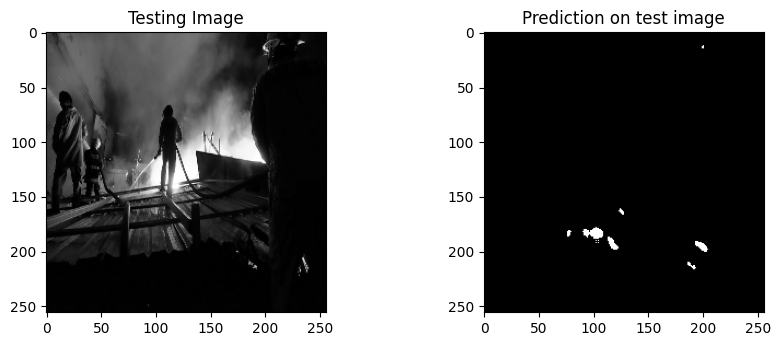

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


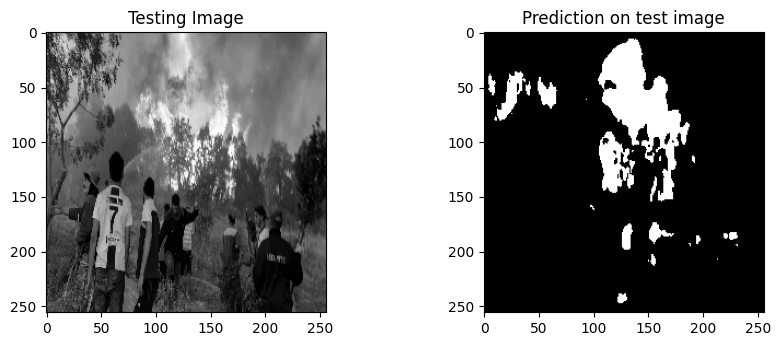

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


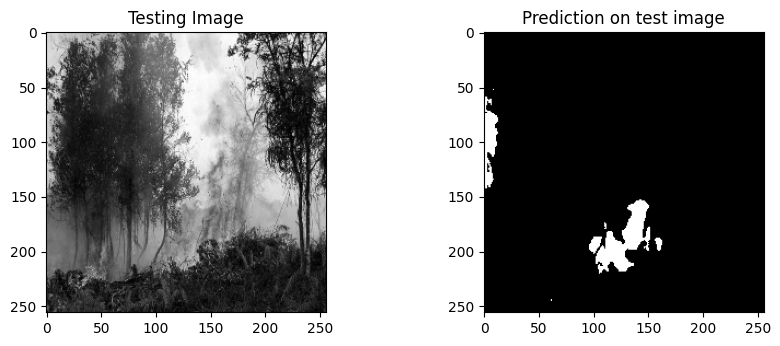

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


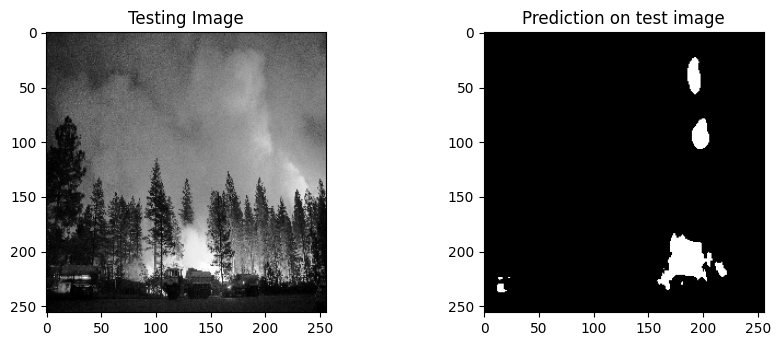

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


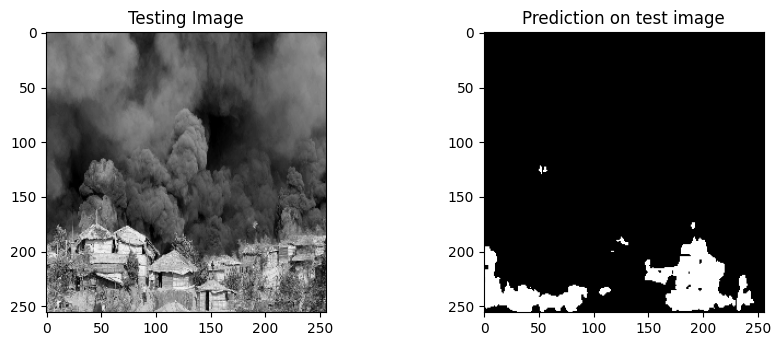

In [67]:
# test the model on a new image
# Load the image
image_names = glob.glob('dataset/testing/fire/*.jpg')
for image_name in image_names:
    image = cv2.imread(image_name, 0)
    image = cv2.resize(image, (SIZE, SIZE))
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)
    image = image / 255.0
    prediction = model.predict(image)
    prediction = (prediction[0, :, :, 0] > threshold).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.subplot(232)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')
    plt.show()

In [ ]:
image_names = glob.glob('dataset/testing/fire/*.jpg')
testing = [cv2.imread(img, 0) for img in image_names]
rgb_images = [cv2.imread(img) for img in image_names]
rgb_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in rgb_images]

resized_images = []

for image in testing:
    # Resize the image to a specific width and height
    resized_image = cv2.resize(image, (SIZE, SIZE))
    resized_images.append(resized_image)

# Convert the list of resized images to a NumPy array
testing_dataset = np.array(resized_images)
# Convert the list of images to a NumPy array
# image_dataset = np.array(images)
testing_dataset = np.expand_dims(testing_dataset, axis = 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


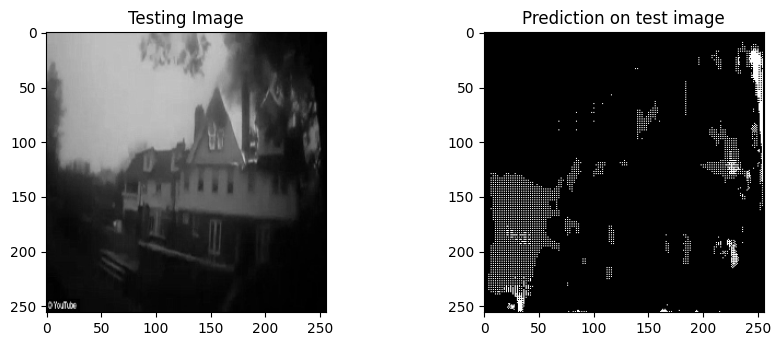

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


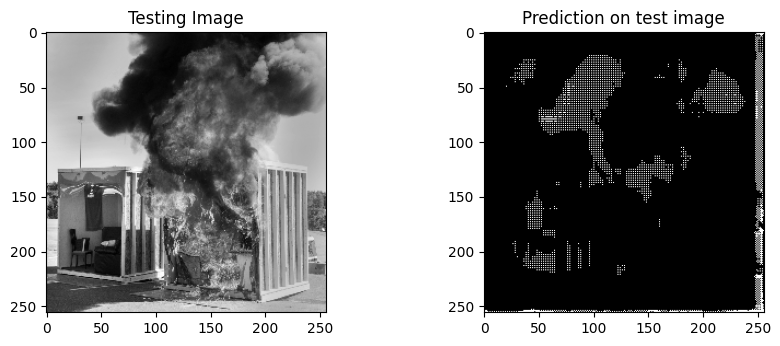

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


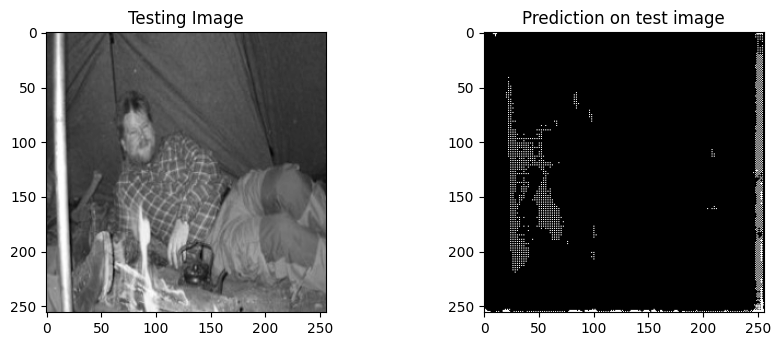

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


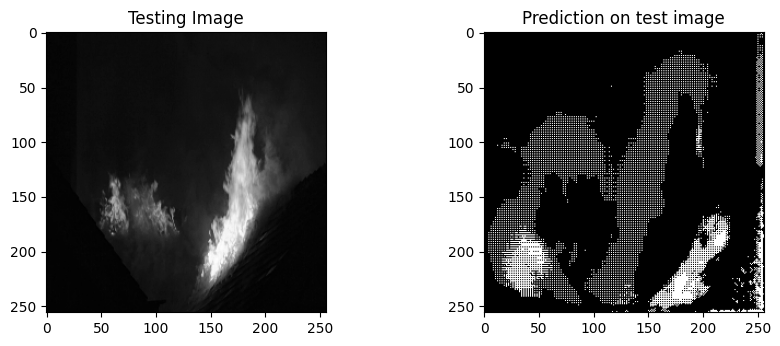

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


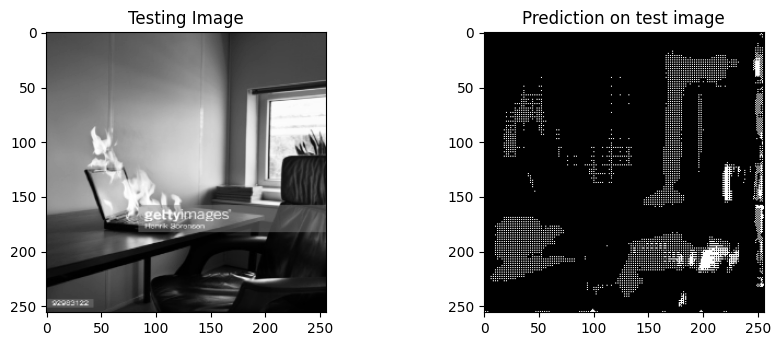

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


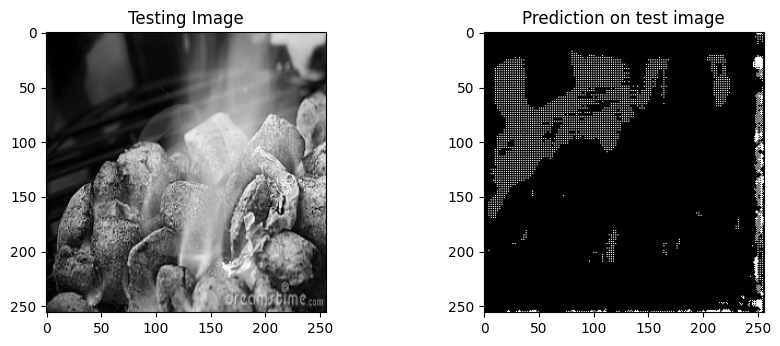

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


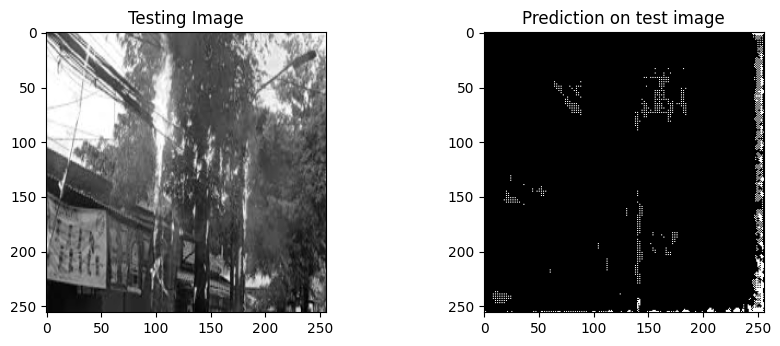

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


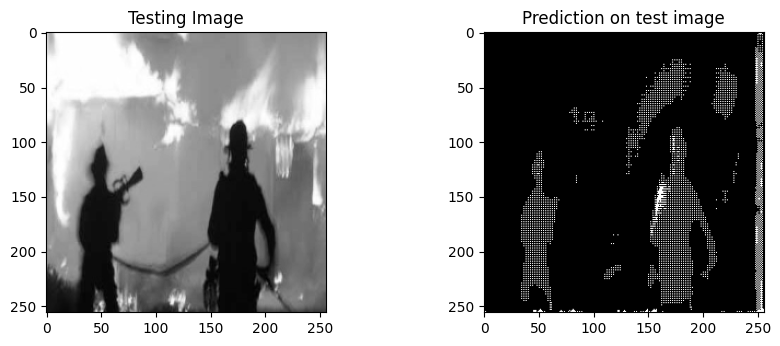

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


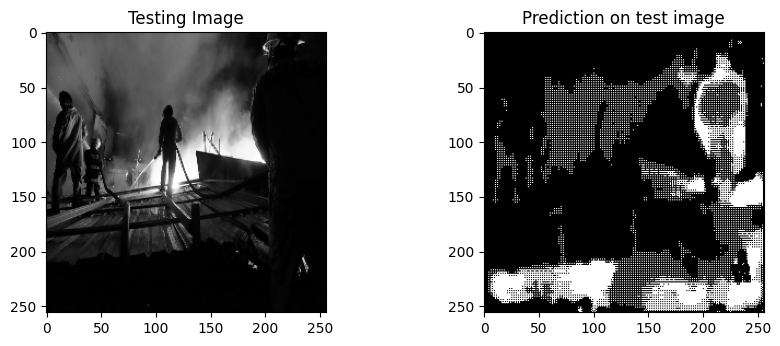

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


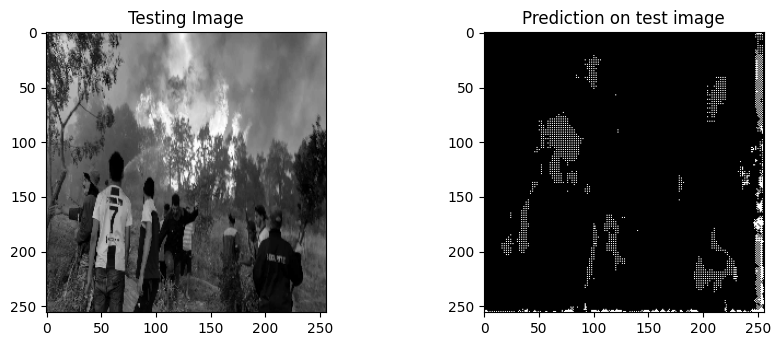

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


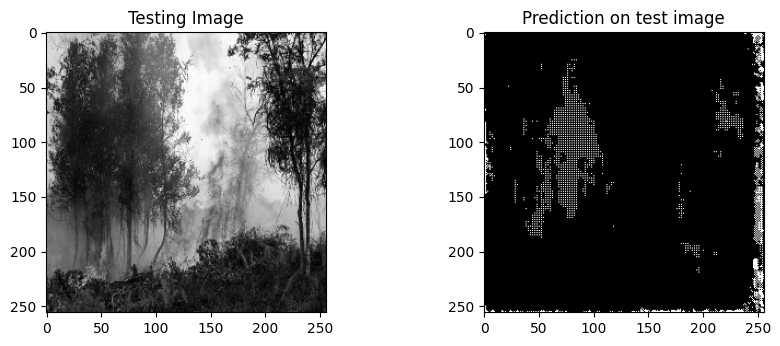

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


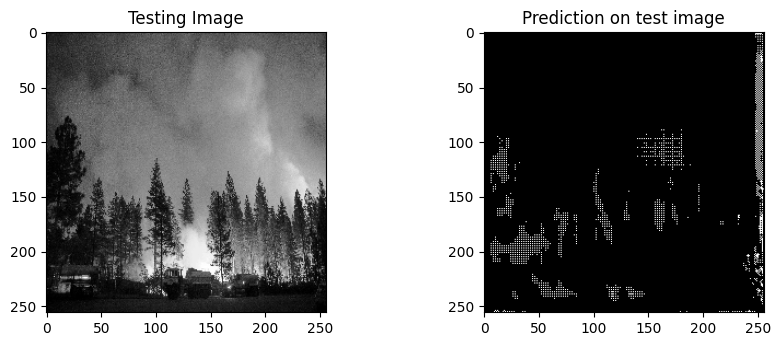

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


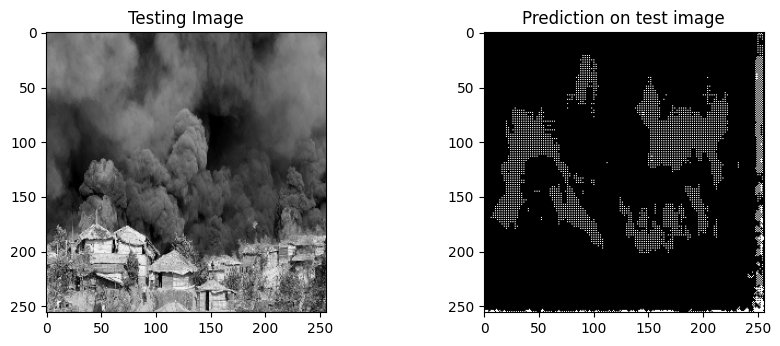

In [64]:
for img in testing_dataset:
    test_img = img
    test_img_input = np.expand_dims(test_img, 0)

    # Obtain the prediction
    prediction = (model.predict(test_img_input)[0, :, :, 0] > threshold).astype(np.uint8)
    
    # Plotting the results
    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:, :, 0], cmap='gray')
    plt.subplot(232)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')
    
    plt.show()